In [1]:
from pyspark.sql.functions import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
def ETL_1_day(path, name):
    # read and create data for 1 day. 
    file_list = os.listdir(f'{path}/{name}')
    parquet_file = [file_name for file_name in file_list if file_name.endswith(".parquet")]
    df = spark.read.parquet(f'{path}/{name}/{parquet_file[0]}')
    df = df.withColumn('Month', lit(name[5:6]))
    return df



In [4]:
def ETL_all_day(folder_path):
    folder_list = os.listdir(folder_path)
    # read data 1 day
    df = ETL_1_day(path = folder_path, name = folder_list[0])
    # read data 30 days
    for file in folder_list[1:]:
        df1 = ETL_1_day(path = folder_path, name = file)
        df = df.union(df1)
        df = df.cache()
    # filter out searching action of valid user_id and keywords
    df = df.filter((col('action') == 'search') & (col('user_id').isNotNull()) & (col('keyword').isNotNull()))
    return df

In [5]:
def most_search(df, month):
    #find out the most-searched keyword
    df = df.filter(col('Month') == month)
    df = df.select('user_id', 'keyword', 'Month')
    df = df.groupBy('user_id', 'keyword', 'Month').count()
    df = df.withColumnRenamed('count', 'Total_search').orderBy('Total_search', ascending= False)
    window = Window.partitionBy('user_id').orderBy(col('Total_search').desc())
    df = df.withColumn('Rank', row_number().over(window))
    df = df.filter(col('Rank') == 1)
    df = df.withColumnRenamed('keyword','Most_Search')
    df = df.select('user_id','Most_Search', 'Month')
    return df
    

In [6]:
folder_path = 'D:\\test\\log_search'
df = ETL_all_day(folder_path)
df.show(10)
    

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "c:\Users\Admin\anaconda3\lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "c:\Users\Admin\anaconda3\lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "c:\Users\Admin\anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
df_t6 = most_search(df, month=6)
df_t7 = most_search(df, month=7)

In [ ]:
df_t6.show()

+-------+--------------------+-----+
|user_id|         Most_Search|Month|
+-------+--------------------+-----+
|0000402|xem phim nhan duy...|    6|
|0003361|         tây hành kỷ|    6|
|0004287|          thuyếtminh|    6|
|0005748|   lời nguyền ma lai|    6|
|0007284|hay goi toi la to...|    6|
|0007564|            hai thế |    6|
|0008207|               CONAN|    6|
|0008416|               tenis|    6|
|0017222|            BAO NGAM|    6|
|0017684|sứ mệnh cuói cung...|    6|
|0017845|           hoạt hình|    6|
|0019650|                hori|    6|
|0019920|           thiếu nhi|    6|
|0021489|           forgotten|    6|
|0022120|         vua bánh mì|    6|
|0023088|        on sport new|    6|
|0023140|pháp y tần minh: ...|    6|
|0024611|                 spy|    6|
|0027497|     bang chung thep|    6|
|0027835|   lời nói dối của h|    6|
+-------+--------------------+-----+
only showing top 20 rows



In [ ]:
df_t7.show()

+-------+--------------------+-----+
|user_id|         Most_Search|Month|
+-------+--------------------+-----+
|0000699|             thả thí|    7|
|0003361|         lộc đỉnh ký|    7|
|0004999|   vụ mất tích bí ẩn|    7|
|0005748|chuyen sinh thanh...|    7|
|0008207|     TIENG ANH LOP 5|    7|
|0008226|        youth of may|    7|
|0009683|     khu vườn bí mật|    7|
|0010311|siêu anh hùng shezow|    7|
|0010652|              bolero|    7|
| 001094|           MA TRAN 1|    7|
|0011135|nhạc sinh nhật ka...|    7|
|0012353|              nam đế|    7|
|0013655|                 u19|    7|
|0013936|            one pice|    7|
|0014187|   điệp viên ẩn danh|    7|
|0016249|             bão cát|    7|
|0017684|       bác sĩ yo han|    7|
|0019650| classroomoftheelite|    7|
|0019920|              bolero|    7|
|0020372|    cổ máy thời gian|    7|
+-------+--------------------+-----+
only showing top 20 rows



In [ ]:
key_dict_pd_t6 = pd.read_excel('D:\\test\\python_project\\cleaned_data\\sample_df_t6_2.xlsx')
key_dict_t6 = spark.createDataFrame(key_dict_pd_t6)
key_dict_pd_t7 = pd.read_excel('D:\\test\\python_project\\cleaned_data\\sample_df_t7_1.xlsx')
key_dict_t7 = spark.createDataFrame(key_dict_pd_t7)

In [ ]:
key_dict_pd_t6.head(100)

,Most_Search,Month,category
0,xem phim nhan duyen tien dinh thailan,6,Thai_drama
1,vuot nguc,6,action
2,thuyếtminh,6,uncleared
3,lời nguyền ma lai,6,Thai_drama
4,hay goi toi la tong giam doc,6,C_drama
...,...,...,...
95,đối tuyển Việt Nam đã giao hữu 1/6/2022,6,football
96,Sát Thủ John Wick,6,action
97,yêu trong đau thương,6,K_drama
98,ba kiếp may mắn gặp được em,6,C_drama


In [ ]:
df_t6 = df_t6.join(key_dict_t6,'Most_search','inner').select('user_id','Most_search','Category')
df_t6 = df_t6.withColumnRenamed('Most_search','Most_Search_t6').withColumnRenamed('Category','Category_t6')
df_t6.show()

+-------+--------------------+-----------+
|user_id|      Most_Search_t6|Category_t6|
+-------+--------------------+-----------+
|0000402|xem phim nhan duy...| Thai_drama|
|0004287|          thuyếtminh| uncleared |
|0005748|   lời nguyền ma lai| Thai_drama|
|0007284|hay goi toi la to...|    C_drama|
|0008207|               CONAN|      anime|
|0008207|               CONAN|      anime|
|0008416|               tenis|   football|
|0017222|            BAO NGAM|     action|
|0017684|sứ mệnh cuói cung...|    K_drama|
|0017845|           hoạt hình|      anime|
|0019650|                hori|      anime|
|0019920|           thiếu nhi|      anime|
|0019920|           thiếu nhi|      anime|
|0019920|           thiếu nhi|      anime|
|0021489|           forgotten| uncleared |
|0022120|         vua bánh mì|    K_drama|
|0023088|        on sport new|   football|
|0023140|pháp y tần minh: ...|    C_drama|
|0023140|pháp y tần minh: ...|    C_drama|
|0024611|                 spy|      anime|
+-------+--

In [ ]:
df_t7 = df_t7.join(key_dict_t7,'Most_search','inner').select('user_id','Most_search','Category')
df_t7 = df_t7.withColumnRenamed('Most_search','Most_Search_t7').withColumnRenamed('Category','Category_t7')
df_t7.show()

+-------+--------------------+-----------+
|user_id|      Most_Search_t7|Category_t7|
+-------+--------------------+-----------+
|0000699|             thả thí|    C_drama|
|0003361|         lộc đỉnh ký|    C_drama|
|0004999|   vụ mất tích bí ẩn|  uncleared|
|0005748|chuyen sinh thanh...|      anime|
|0008207|     TIENG ANH LOP 5|  uncleared|
|0008226|        youth of may|    K_drama|
|0009683|     khu vườn bí mật|    K_drama|
|0009683|     khu vườn bí mật|    K_drama|
|0010652|              bolero|      music|
|0010652|              bolero|      music|
|0010652|              bolero|      music|
|0011135|nhạc sinh nhật ka...|      music|
|0012353|              nam đế|  uncleared|
|0013655|                 u19|   football|
|0013655|                 u19|   football|
|0013655|                 u19|   football|
|0013655|                 u19|   football|
|0013655|                 u19|   football|
|0013936|            one pice|      anime|
|0014187|   điệp viên ẩn danh|      anime|
+-------+--

In [ ]:
df_final = df_t6.join(df_t7, "user_id",'inner')

In [ ]:
df_final = df_final.withColumn('Category_change', when(col('Category_t6')==col('Category_t7'),'Unchanged').otherwise(concat(df_final['Category_t6'],lit('-'),df_final['Category_t7'])))

In [ ]:
df_final.show(100)

+-------+--------------------+-----------+--------------------+-----------+--------------------+
|user_id|      Most_Search_t6|Category_t6|      Most_Search_t7|Category_t7|     Category_change|
+-------+--------------------+-----------+--------------------+-----------+--------------------+
|0005748|   lời nguyền ma lai| Thai_drama|chuyen sinh thanh...|      anime|    Thai_drama-anime|
|0008207|               CONAN|      anime|     TIENG ANH LOP 5|  uncleared|     anime-uncleared|
|0008207|               CONAN|      anime|     TIENG ANH LOP 5|  uncleared|     anime-uncleared|
|0017684|sứ mệnh cuói cung...|    K_drama|       bác sĩ yo han|    K_drama|           Unchanged|
|0019650|                hori|      anime| classroomoftheelite|      anime|           Unchanged|
|0019920|           thiếu nhi|      anime|              bolero|      music|         anime-music|
|0019920|           thiếu nhi|      anime|              bolero|      music|         anime-music|
|0019920|           thiếu nhi|

In [ ]:
USER = 'root'
PASSWORD = '1'
HOST = 'localhost'
PORT = '3306'
DB_NAME = 'data_engineering'
URL = 'jdbc:mysql://' + HOST + ':' + PORT + '/' + DB_NAME
DRIVER = "com.mysql.cj.jdbc.Driver"
df_final.write.format("jdbc") \
        .option('driver', DRIVER) \
        .option('url', URL) \
        .option('dbtable', 'bigdata') \
        .mode('append') \
        .option('user', USER) \
        .option('password', PASSWORD) \
        .save()

Py4JJavaError: An error occurred while calling o431.save.
: com.mysql.cj.jdbc.exceptions.CommunicationsException: Communications link failure

The last packet sent successfully to the server was 0 milliseconds ago. The driver has not received any packets from the server.
	at com.mysql.cj.jdbc.exceptions.SQLError.createCommunicationsException(SQLError.java:174)
	at com.mysql.cj.jdbc.exceptions.SQLExceptionsMapping.translateException(SQLExceptionsMapping.java:64)
	at com.mysql.cj.jdbc.ConnectionImpl.createNewIO(ConnectionImpl.java:828)
	at com.mysql.cj.jdbc.ConnectionImpl.<init>(ConnectionImpl.java:448)
	at com.mysql.cj.jdbc.ConnectionImpl.getInstance(ConnectionImpl.java:241)
	at com.mysql.cj.jdbc.NonRegisteringDriver.connect(NonRegisteringDriver.java:198)
	at org.apache.spark.sql.execution.datasources.jdbc.connection.BasicConnectionProvider.getConnection(BasicConnectionProvider.scala:49)
	at org.apache.spark.sql.execution.datasources.jdbc.connection.ConnectionProviderBase.create(ConnectionProvider.scala:102)
	at org.apache.spark.sql.jdbc.JdbcDialect.$anonfun$createConnectionFactory$1(JdbcDialects.scala:123)
	at org.apache.spark.sql.jdbc.JdbcDialect.$anonfun$createConnectionFactory$1$adapted(JdbcDialects.scala:119)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:50)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:47)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:75)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:73)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:84)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:118)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:195)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:103)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:827)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:94)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:512)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:104)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:512)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:488)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:94)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:81)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:79)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:133)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:856)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:387)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:360)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:247)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)
Caused by: com.mysql.cj.exceptions.CJCommunicationsException: Communications link failure

The last packet sent successfully to the server was 0 milliseconds ago. The driver has not received any packets from the server.
	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(Unknown Source)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(Unknown Source)
	at java.lang.reflect.Constructor.newInstance(Unknown Source)
	at com.mysql.cj.exceptions.ExceptionFactory.createException(ExceptionFactory.java:61)
	at com.mysql.cj.exceptions.ExceptionFactory.createException(ExceptionFactory.java:105)
	at com.mysql.cj.exceptions.ExceptionFactory.createException(ExceptionFactory.java:151)
	at com.mysql.cj.exceptions.ExceptionFactory.createCommunicationsException(ExceptionFactory.java:167)
	at com.mysql.cj.protocol.a.NativeSocketConnection.connect(NativeSocketConnection.java:89)
	at com.mysql.cj.NativeSession.connect(NativeSession.java:120)
	at com.mysql.cj.jdbc.ConnectionImpl.connectOneTryOnly(ConnectionImpl.java:948)
	at com.mysql.cj.jdbc.ConnectionImpl.createNewIO(ConnectionImpl.java:818)
	... 49 more
Caused by: java.net.ConnectException: Connection refused: connect
	at java.net.DualStackPlainSocketImpl.connect0(Native Method)
	at java.net.DualStackPlainSocketImpl.socketConnect(Unknown Source)
	at java.net.AbstractPlainSocketImpl.doConnect(Unknown Source)
	at java.net.AbstractPlainSocketImpl.connectToAddress(Unknown Source)
	at java.net.AbstractPlainSocketImpl.connect(Unknown Source)
	at java.net.PlainSocketImpl.connect(Unknown Source)
	at java.net.SocksSocketImpl.connect(Unknown Source)
	at java.net.Socket.connect(Unknown Source)
	at com.mysql.cj.protocol.StandardSocketFactory.connect(StandardSocketFactory.java:153)
	at com.mysql.cj.protocol.a.NativeSocketConnection.connect(NativeSocketConnection.java:63)
	... 52 more


In [ ]:
DF_T6 = df_t6.toPandas()

In [ ]:
DF_T7 = df_t7.toPandas()

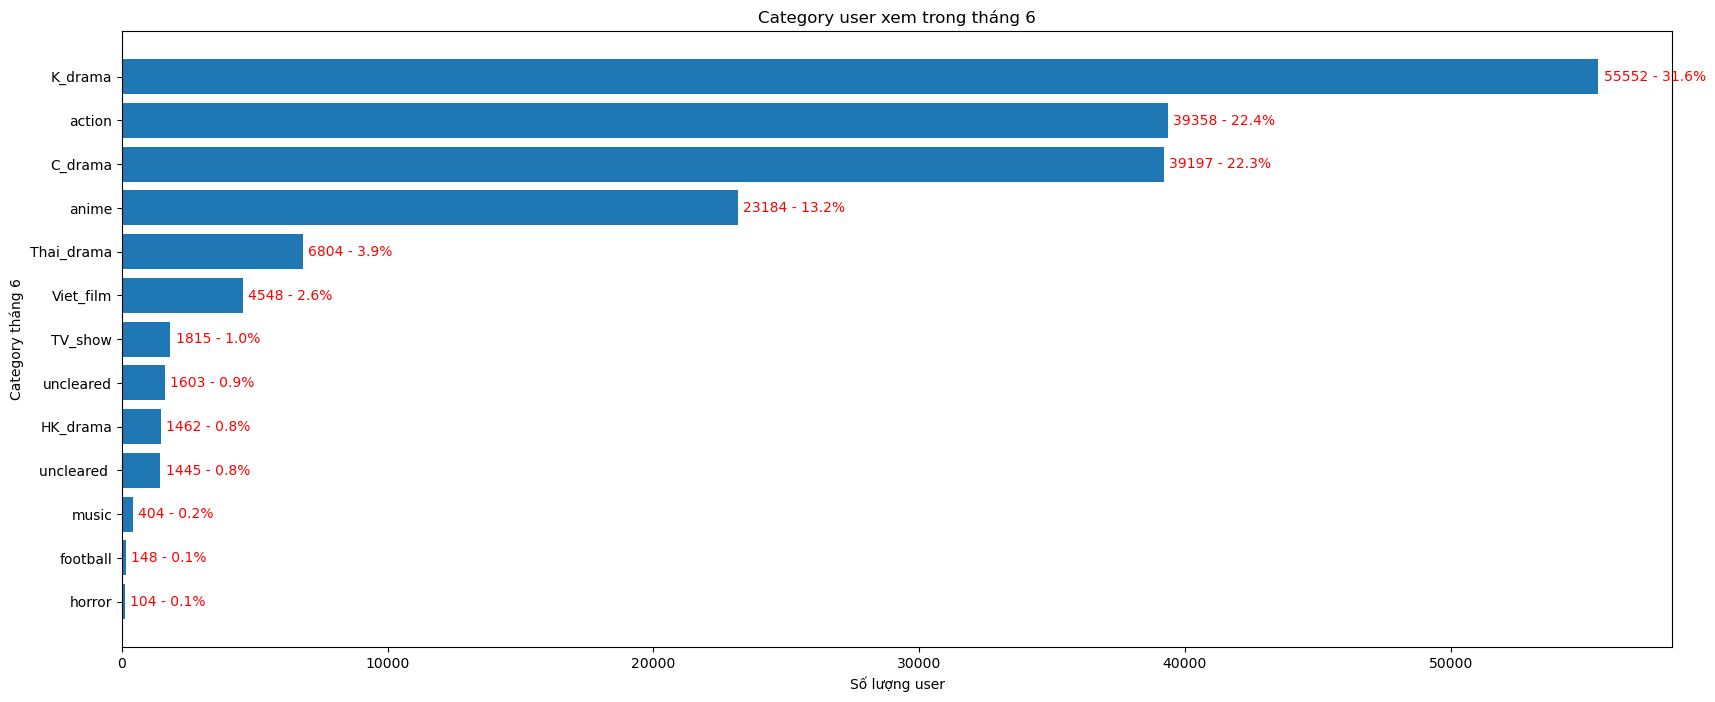

In [ ]:


plt.figure(figsize=(20, 8))
y = DF_T6['Category_t6'].value_counts().index
x = DF_T6['Category_t6'].value_counts().values
padding = 200

# Calculate the total count for percentage calculation
total_count = x.sum()

# Use enumerate to simplify the loop
for i, count in enumerate(x):
    percentage = (count / total_count) * 100
    plt.text(count + padding, i, f'{count} - {percentage:.1f}%', ha='left', va='center', color='red')

plt.barh(y, x)
plt.xlabel('Số lượng user')
plt.ylabel('Category tháng 6')
plt.title('Category user xem trong tháng 6')
plt.gca().invert_yaxis()

plt.show()


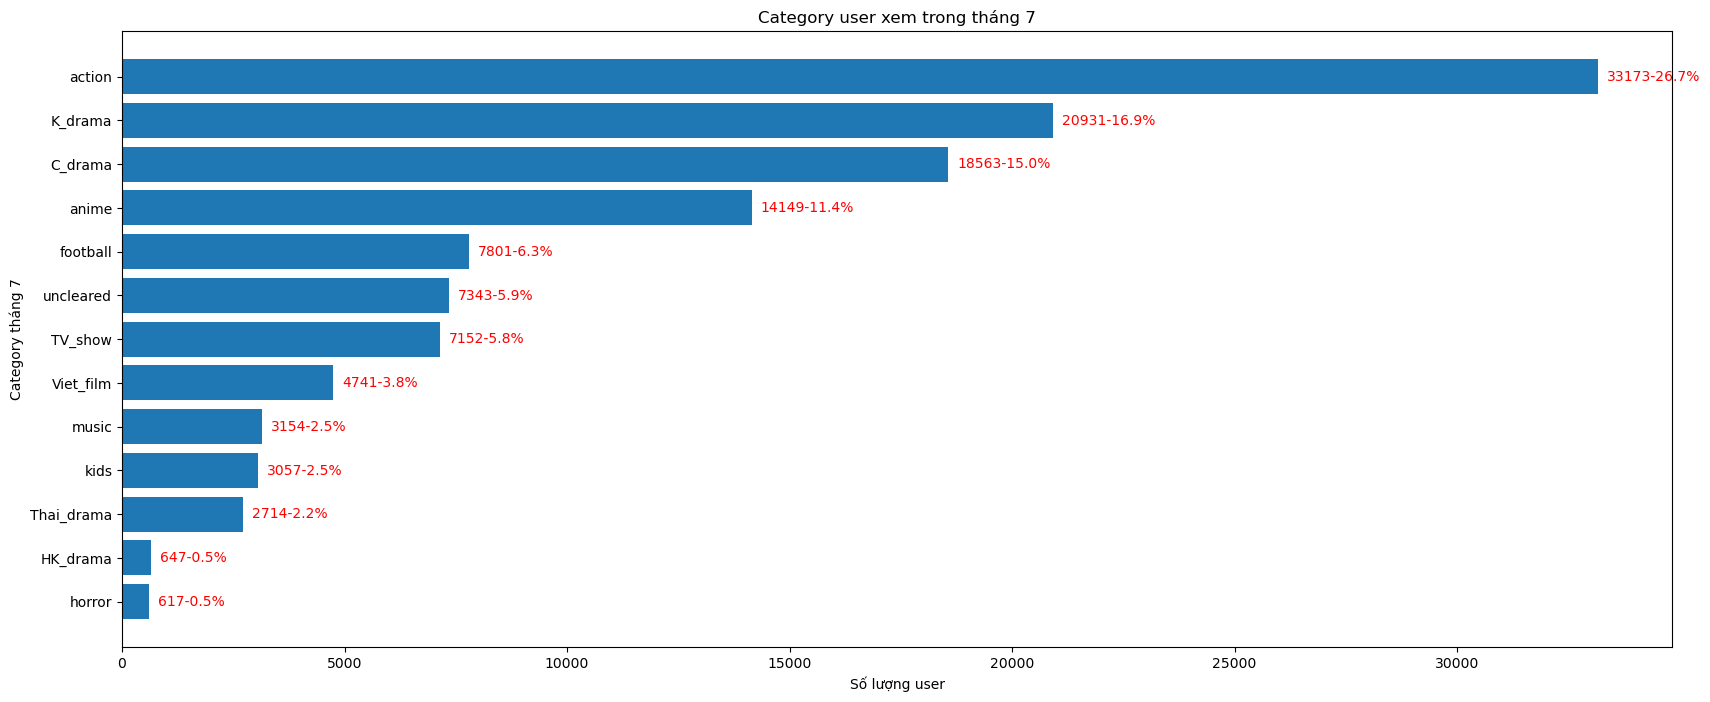

In [ ]:
DF_T7 = df_t7.toPandas()
plt.figure(figsize=(20,8))
y = DF_T7['Category_t7'].value_counts().index
x = DF_T7['Category_t7'].value_counts().values
padding = 200
for i in range(len(x)):
    plt.text(x[i] + padding, i, str(x[i]) + '-' + (f'{(x[i] / (x.sum())) * 100:.1f}%'), ha='left', va='center', color = 'red')
plt.barh(y,x)
plt.xlabel('Số lượng user')
plt.ylabel('Category tháng 7')
plt.title('Category user xem trong tháng 7')
plt.gca().invert_yaxis()


In [ ]:
DF_FINAL = df_final.toPandas()

In [ ]:
DF_FINAL.head(100)

,user_id,Most_Search_t6,Category_t6,Most_Search_t7,Category_t7,Category_change
0,0005748,lời nguyền ma lai,Thai_drama,chuyen sinh thanh nhen,anime,Thai_drama-anime
1,0008207,CONAN,anime,TIENG ANH LOP 5,uncleared,anime-uncleared
2,0008207,CONAN,anime,TIENG ANH LOP 5,uncleared,anime-uncleared
3,0017684,sứ mệnh cuói cung cua thien than,K_drama,bác sĩ yo han,K_drama,Unchanged
4,0019650,hori,anime,classroomoftheelite,anime,Unchanged
...,...,...,...,...,...,...
95,0392220,mộng hoa lục,C_drama,lang nha bảng,C_drama,Unchanged
96,0392220,mộng hoa lục,C_drama,lang nha bảng,C_drama,Unchanged
97,0392220,mộng hoa lục,C_drama,lang nha bảng,C_drama,Unchanged
98,0392220,mộng hoa lục,C_drama,lang nha bảng,C_drama,Unchanged


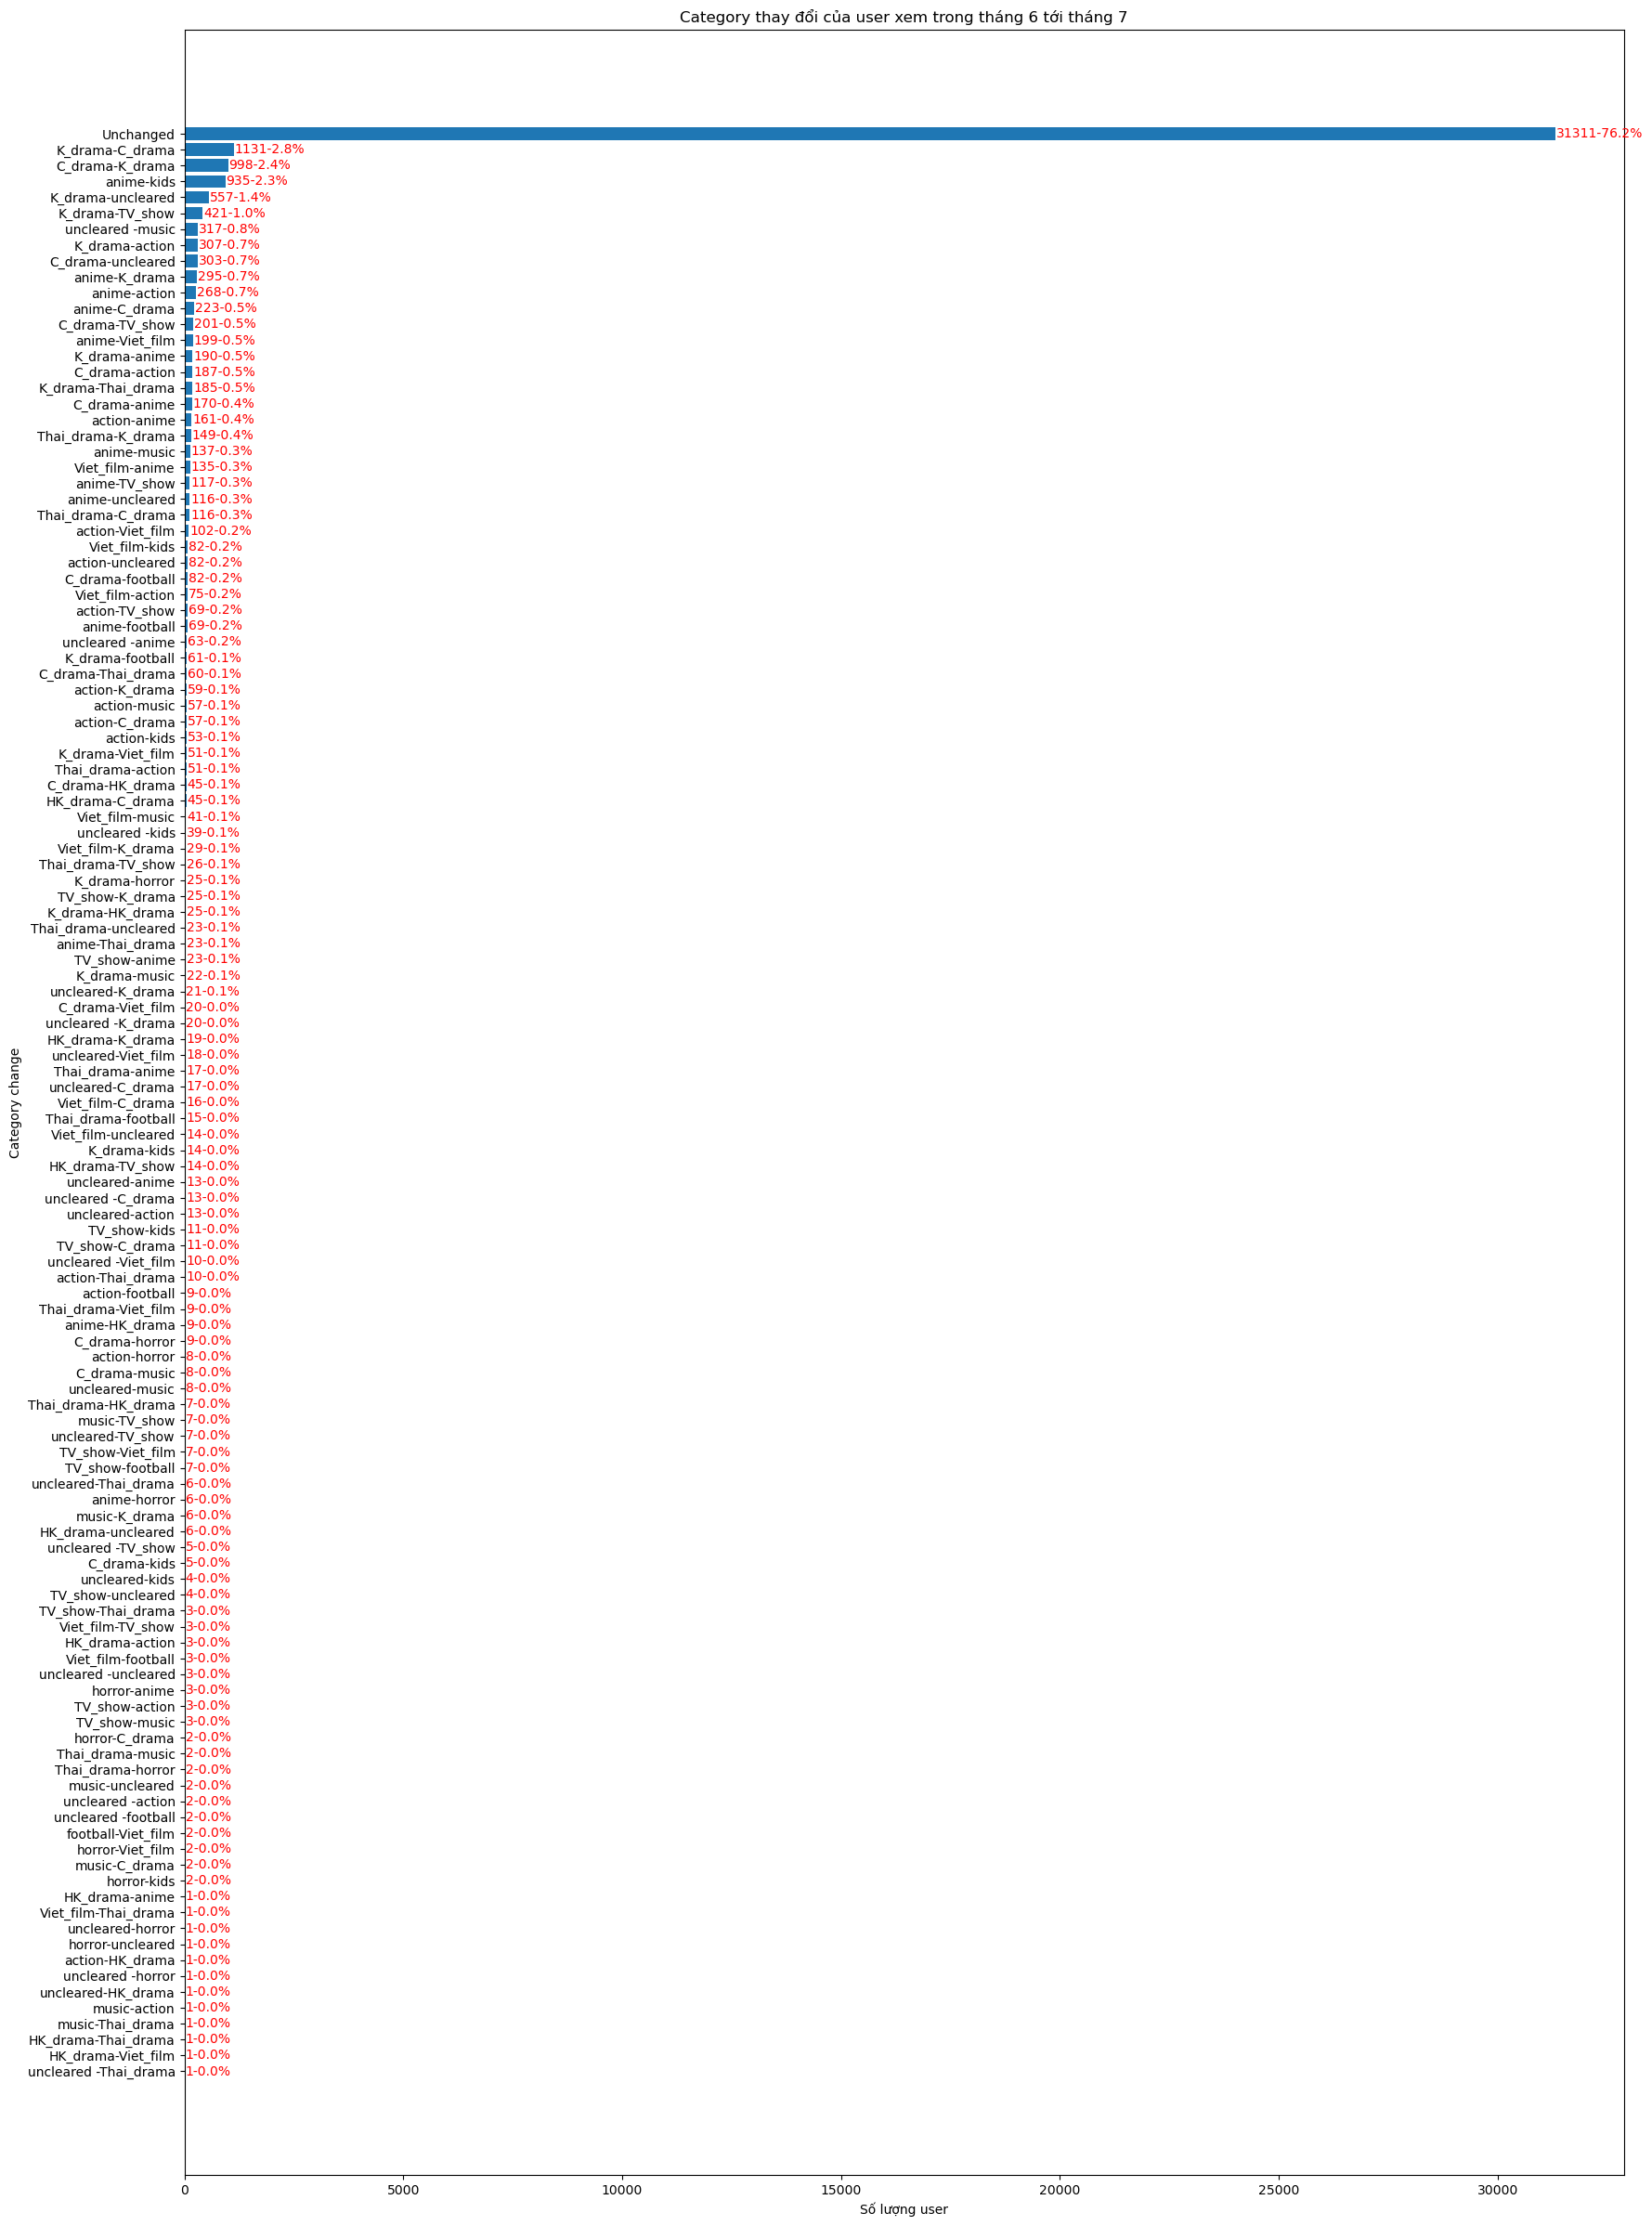

In [ ]:
plt.figure(figsize=(20,30))
y = DF_FINAL['Category_change'].value_counts().index
x = DF_FINAL['Category_change'].value_counts().values
padding = 20
for i in range(len(x)):
    plt.text(x[i] + padding, i, str(x[i]) + '-' + (f'{(x[i] / (x.sum())) * 100:.1f}%'), ha='left', va='center', color = 'red')
plt.barh(y,x)
plt.xlabel('Số lượng user')
plt.ylabel('Category change')
plt.title('Category thay đổi của user xem trong tháng 6 tới tháng 7')
plt.gca().invert_yaxis()